In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
# Load dataset from Google Drive
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Fabric",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 1438 files belonging to 5 classes.


In [6]:
class_names = dataset.class_names
class_names

['cotton', 'denim', 'net', 'silk', 'wool']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 4 4 0 3 1 0 0 3 0 1 4 1 0 0 3 0 1 1 3 4 1 1 2 0 1 0 2 3 2 0]


# **Visualize some of the images from our dataset**

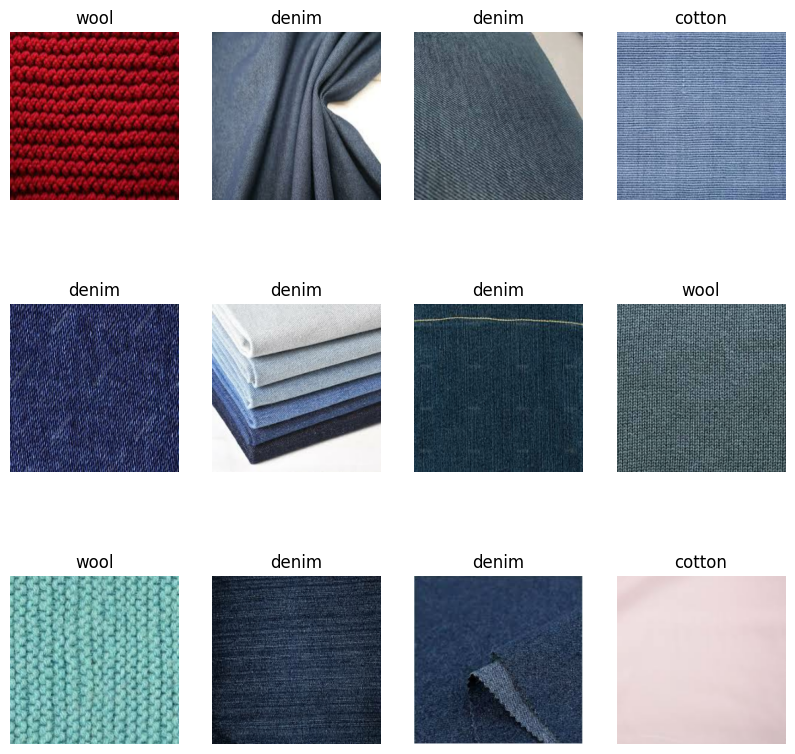

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

*   Training: Dataset to be used while training
*   Validation: Dataset to be tested against while training
*   Test: Dataset to be tested against after we trained a model






In [9]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=110):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
len(dataset)  #batches count

45

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print('Train data batches',len(train_ds))
print('Validate data batches',len(val_ds))
print('Test data batches',len(test_ds))

Train data batches 31
Validate data batches 6
Test data batches 8


# Cache, Shuffle, and Prefetch the Dataset

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

Creating a Layer for Resizing and Normalization

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.preprocessing.Rescaling(1./255),
])

***Data Augmentation***

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

***Applying Data Augmentation to Train Dataset***

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**


*   CNN coupled with a Softmax activation in the output layer
*    initial layers for resizing, normalization and Data Augmentation.



In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model
used adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [22]:
print("Shape of train_ds: ",train_ds)

Shape of train_ds:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [23]:
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds.apply(tf.data.experimental.ignore_errors())

history = model.fit(
    train_ds,
    epochs=65,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Epoch 1/65
     31/Unknown 440s 326ms/step - accuracy: 0.2702 - loss: 1.5861

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 452s 726ms/step - accuracy: 0.2716 - loss: 1.5848 - val_accuracy: 0.3958 - val_loss: 1.4261
Epoch 2/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.3564 - loss: 1.4350 - val_accuracy: 0.3906 - val_loss: 1.3922
Epoch 3/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 669ms/step - accuracy: 0.3980 - loss: 1.3637 - val_accuracy: 0.4010 - val_loss: 1.3522
Epoch 4/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.4479 - loss: 1.2798 - val_accuracy: 0.4271 - val_loss: 1.3530
Epoch 5/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step - accuracy: 0.4519 - loss: 1.2826 - val_accuracy: 0.4844 - val_loss: 1.2620
Epoch 6/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.4899 - loss: 1.2196 - val_accuracy: 0.4323 - val_loss: 1.3103
Epoch 7/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.5212 - loss: 1.1772 - val_accuracy: 0.5521 - val_loss: 1.1703
Epoch 8/65
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.5445 - loss: 1.1509 - val_accuracy: 0.63

# Plotting the Accuracy and Loss Curves

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 65, 'steps': None}

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

65

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5454734563827515,
 1.4018288850784302,
 1.3671677112579346,
 1.2665736675262451,
 1.2453069686889648]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

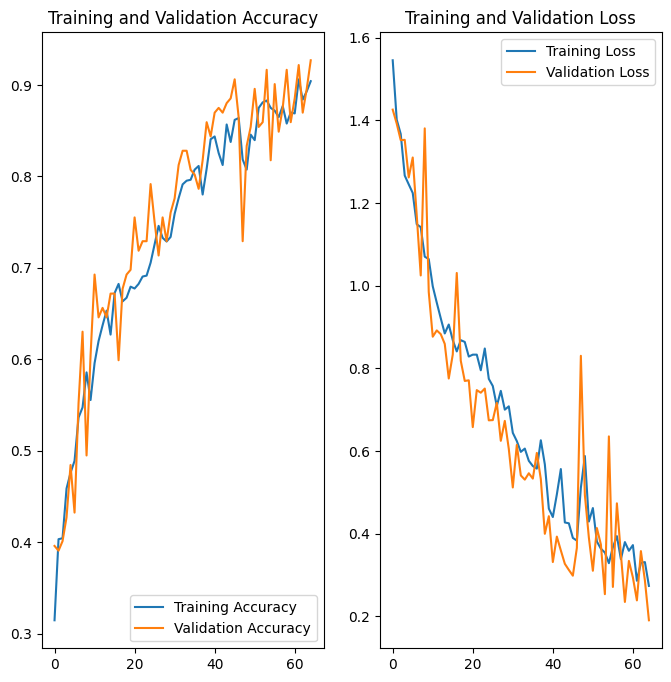

In [31]:
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(min(len(acc))), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(min(len(acc), len(val_acc))), acc[:min(len(acc), len(val_acc))], label='Training Accuracy')
plt.plot(range(min(len(acc), len(val_acc))), val_acc[:min(len(acc), len(val_acc))], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(min(len(loss), len(val_loss))), loss[:min(len(loss), len(val_loss))], label='Training Loss')
plt.plot(range(min(len(loss), len(val_loss))), val_loss[:min(len(loss), len(val_loss))], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: silk
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
predicted label: silk
first image to predict
actual label: silk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted label: silk
first image to predict
actual label: wool
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
predicted label: denim
first image to predict
actual label: denim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
predicted label: denim
first image to predict
actual label: denim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
predicted label: denim
first image to predict
actual label: wool
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted label: wool
first image to predict
actual label: wool
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
predicted label: wool


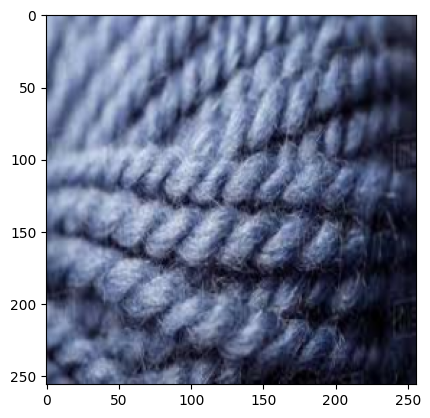

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(8):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

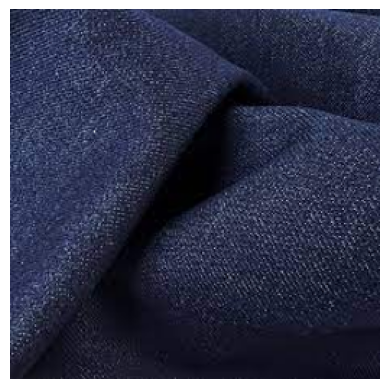

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: denim
Confidence: 99.48


In [34]:
from PIL import Image
# Class names
class_names = ['cotton', 'denim', 'net', 'silk', 'wool']

def preprocess_image(image_path):
    image = np.array(
        Image.open(image_path).convert("RGB").resize((256, 256)) # image resizing
    )
    return image

# Path to your image
image_path = "/content/drive/MyDrive/Fabric/denim/images - 2025-05-17T211024.643.jpg"
preprocessed_image = preprocess_image(image_path)

# Display the preprocessed image
import matplotlib.pyplot as plt
plt.imshow(preprocessed_image)
plt.axis('off')
plt.show()

# Make predictions
img_array = tf.expand_dims(preprocessed_image, 0)
predictions = model.predict(img_array)

# Get predicted class and confidence
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]
confidence = round(100 * np.max(predictions[0]), 2)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)


# Write a function for inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


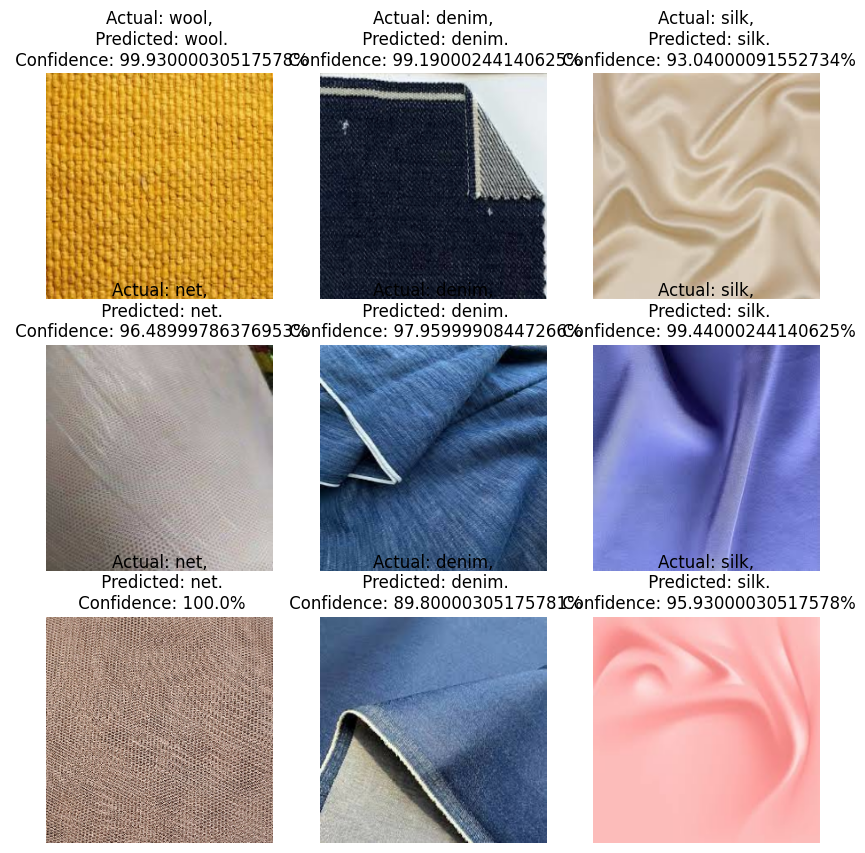

In [36]:
#run inference on few sample images
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving the Model

In [37]:
# import os
# model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/models") + [0]])+1
# model.save(f"/content/drive/MyDrive/models/{model_version}")

In [38]:
model.save("/content/drive/MyDrive/models/fabric.h5")